In [253]:
import math
import numpy as np
import pandas as pd
import os
import tempfile
import random
import datetime

from scipy.spatial.distance import pdist, squareform
import scipy.io as sio

import seaborn as sbn

import matplotlib.pyplot as plt

%matplotlib inline

In [220]:
paxout = pd.read_csv('ignored_assets/paxout_table.csv')
paxout['time_bucket'] = pd.to_datetime(paxout['time_bucket'])
paxout= paxout.set_index('time_bucket')
paxout2 = paxout[paxout.index < datetime.datetime(2016, 1, 21)]

In [242]:
weekdays = paxout2[paxout2.index.weekday < 5].copy()

In [243]:
weekdays['tot_demand'] = weekdays.sum(axis=1)
weekdays = weekdays[['tot_demand']]
weekdays['time'] = weekdays.index.time
weekdays['date'] = weekdays.index.date

In [244]:
tot_week_days = len(weekdays['date'].unique())

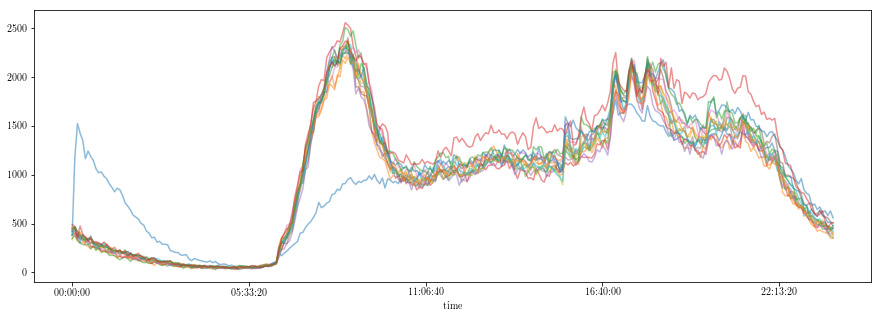

In [245]:
plt.figure(figsize=(15,5))
plt.plot(weekdays.reset_index().pivot(index='time',columns='date',values='tot_demand'), alpha =0.5);#.plot(alpha=0.1, legend=False)

In [246]:
pivotedwd = weekdays.reset_index().pivot(index='time',columns='date',values='tot_demand')

In [247]:
pivotedwd = (pivotedwd.values - pivotedwd.mean(axis=1).values[:,None]) / pivotedwd.mean(axis=1).values[:,None]

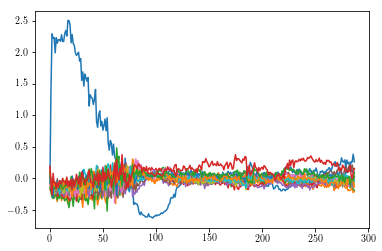

In [249]:
plt.plot(pivotedwd);

In [250]:
mean = weekdays.groupby('time').agg(np.mean)
std = weekdays.groupby('time').agg(np.std)
mx = weekdays.groupby('time').agg(np.max)
mn = weekdays.groupby('time').agg(np.min)

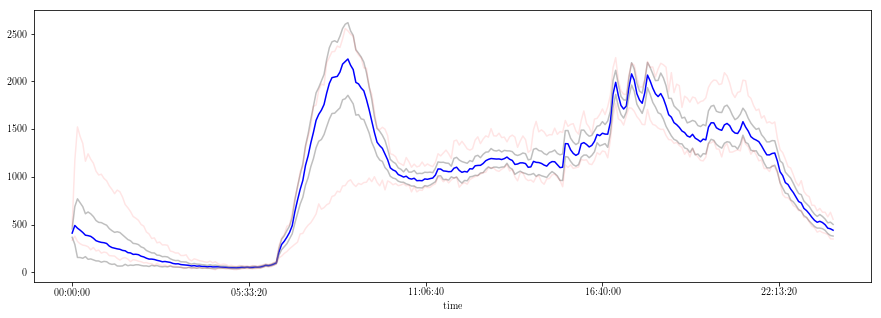

In [251]:
plt.figure(figsize=(15,5))
plt.plot(mean.index, mean['tot_demand'], color= 'blue', alpha=1)
plt.plot(mean.index, mean['tot_demand'] + std['tot_demand'], color= 'gray', alpha=0.5)
plt.plot(mean.index, mean['tot_demand'] - std['tot_demand'], color= 'gray', alpha=0.5)
plt.plot(mean.index, mx['tot_demand'], color= 'red', alpha=0.1)
plt.plot(mean.index, mn['tot_demand'], color= 'red', alpha=0.1)

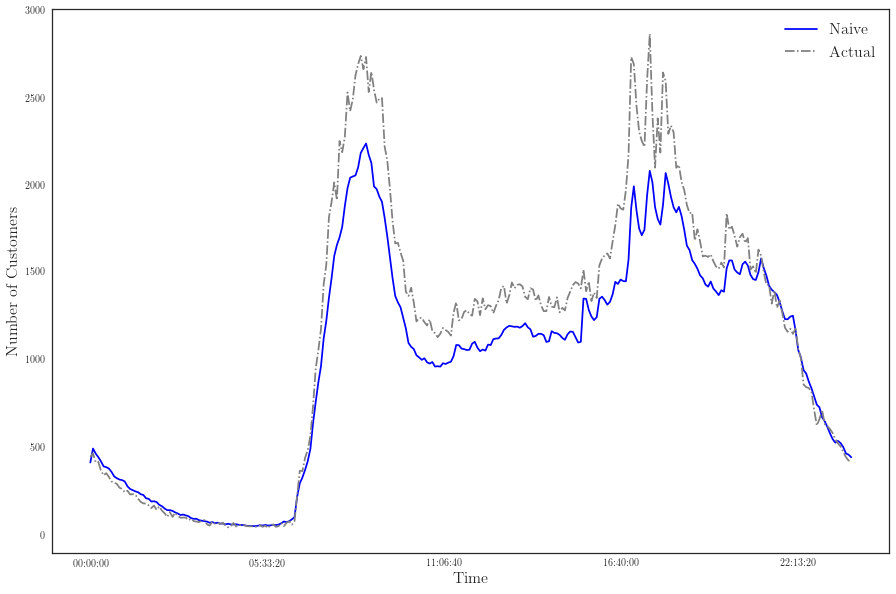

In [255]:
sbn.set(style="white")
plt.figure(figsize=(15,10))

plt.plot(mean.index, mean['tot_demand'].values, color= 'blue', alpha=1, label='Naive');
real = paxout[paxout.index.date == datetime.date(2016, 1, 21)].sum(axis=1)
plt.plot(real.index.time, real.values, color='gray', label='Actual', ls='-.');

plt.ylabel('Number of Customers', fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.legend(fontsize = 16)
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "Computer Modern Roman"
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['text.usetex'] = True
plt.savefig('total_demand_predictions_naive.pdf',bbox_inches='tight')

In [257]:
mean.max()

tot_demand    2235.928571
dtype: float64

## Average/Naive Predictor

In [171]:
orderdf = pd.read_csv('ignored_assets/orders.csv', parse_dates = [6])
# Create map of driver IDs
driver_ids=orderdf['driver_id'].unique()

# create map of core stations
core_stations = orderdf['start_district_hash'].unique()
core_stations.sort()

#Index stuff
orderdf_f=orderdf[(~pd.isnull(orderdf['driver_id'])) & orderdf['dest_district_hash'].isin(core_stations)]
myindex=pd.MultiIndex.from_arrays([orderdf_f['driver_id'],orderdf_f['timestamp']],names=('driver_id','timestamp'))

orderdf2=orderdf_f.set_index(myindex)
orderdf_s=orderdf2.sort_index()

orderdf_s['time_bucket'] = orderdf_s['timestamp'].dt.round('5min')
orderdf_s['pax_arrival_time'] = orderdf_s['timestamp'] + orderdf_s['expected_travel_time'] * pd.Timedelta('1 minute')
orderdf_s['time_bucket_arrival'] = orderdf_s['pax_arrival_time'].dt.round('5min')
orderdf_s['time'] = orderdf_s['time_bucket'].dt.time

stepsize = pd.Timedelta('5 min')
horizon = pd.Timedelta('2 hour')
start = pd.to_datetime('2016-01-21 00:00:00')

nsteps = int(pd.Timedelta('1 day') / stepsize)

In [195]:
pt = pd.pivot_table(orderdf_s[(orderdf_s['time_bucket'] < datetime.datetime(2016, 1, 21)) &
                         (orderdf_s['time_bucket'].dt.weekday < 5)
                        ],
                               index=['time','start_district_hash'], 
                               columns='dest_district_hash', aggfunc=len, 
                               values='order_id', fill_value=0
                              ) / tot_week_days

In [197]:
predictor = np.zeros((nsteps,), dtype=np.object)

for i in range(nsteps):
    begin = start + i*stepsize
    end = begin + horizon
    index = [begin + j*stepsize for j in range(int(horizon / stepsize))]
    predictor[i] = np.zeros((len(index)+1,), dtype=np.object)
    base = pd.DataFrame(
            np.zeros((len(core_stations),len(core_stations)),dtype=np.float64),
            index=core_stations,
            columns = core_stations
        )
    predictor[i][0] = base.as_matrix()
    for j,t in enumerate(index):
        predictor[i][j+1] = (base + pt.loc[t.time()]).fillna(0).as_matrix().round()

In [212]:
tod_predictions  ={
        'predictor': predictor
    }

In [213]:
sio.savemat('ignored_assets/tod_predictions_naive.mat',tod_predictions)